In [94]:
!pip install ipympl
!pip install trimesh
!pip install open3d
!python -m pip install scipy


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement open3d (from versions: none)
ERROR: No matching distribution found for open3d

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
%matplotlib ipympl
import numpy as np
import scipy.spatial as sp
import trimesh
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing

workers = multiprocessing.cpu_count()
np.set_printoptions(linewidth=100)

In [2]:
num_of_frames = 30

point_clouds = []
# Carregando todas as point clouds
for index in range(0, num_of_frames):
    # Usando operador ternario para avaliar se é necessário o 0 a mais
    file_name = "./KITTI-Sequence/0000"+ (("0" + str(index)) if index < 10 else str(index) )+"_points.obj"
    point_cloud = trimesh.load(file_name).vertices
    point_clouds.append(point_cloud)

In [36]:
def icp(source_points, target_points, epsilon = 1e-3, leafsize = 30, balanced_tree=False):

#    def register_points(a, b):
#        a1 = np.column_stack((a,np.ones(a.shape[0])))
#        b1 = np.column_stack((b,np.ones(b.shape[0])))
#
#        matrixA = np.tensordot(a1,a1.T,axes=[0,1])
#        matrixR = np.tensordot(a1,b1.T,axes=[0,1])
#        matrixAinv = np.linalg.inv(matrixA)
#        return np.tensordot(matrixAinv,matrixR,axes=1).transpose() 


    def register_points(p1, p2):
        u1 = np.mean(p1.T, axis=1).reshape((3, 1))
        u2 = np.mean(p2.T, axis=1).reshape((3, 1))
        pp1 = p1.T - u1
        pp2 = p2.T - u2
        W = np.dot(pp1, pp2.T)
        U, _, Vh = np.linalg.svd(W)
        R = np.dot(U, Vh).T
        if np.linalg.det(R) < 0:
            Vh[2, :] *= -1
            R = np.dot(U, Vh).T
        t = u2 - np.dot(R, u1)
        tm = np.eye(4,4)
        tm[:3, :3] = R
        tm[:3, 3] = t.T
        #print(tm)
        return tm
        
        
    # Keeping original points untouched

    source_copy = source_points.copy()
    source_copy = np.column_stack((source_copy,np.ones(source_copy.shape[0])))
    target_copy = target_points.copy()
    target_copy = np.column_stack((target_copy,np.ones(target_copy.shape[0])))
    
    current_points = source_points.copy()
    last_rmse = 0

    while True:
        # Input has to be of shape (N, M) where
        # N = Number of points
        # M = dimensions
        # Thus the transpose is used
        kdt = sp.KDTree(target_points, leafsize = leafsize, balanced_tree=balanced_tree, copy_data=False)
        _, indexes = kdt.query(current_points, k = 1, workers = workers)
        #print(indexes.shape, target_points.shape, current_points.shape)
        # Getting position of queried points
        target_selected = target_points[indexes, :]
        # Calculating transformation Matrix
        transformation_matrix = register_points(source_points, target_selected)

        # Updating current points
        predicted_points = np.dot(transformation_matrix, source_copy.T)

        # Calculating RMSE
        #print(predicted_points.T.shape, target_selected.shape)
        rmse = np.sqrt(np.mean(np.sum((predicted_points.T[:, :3] - target_selected[:, :3]) ** 2, axis=None)))

        if np.abs(rmse - last_rmse) < epsilon:
            return transformation_matrix, rmse
        
        current_points = predicted_points[:3, :].T
        last_rmse = rmse
        
        

In [86]:
def IterativeClosestPoint(source_pts, target_pts, tau=10e-6):
    '''
    This function implements iterative closest point algorithm based 
    on Besl, P.J. & McKay, N.D. 1992, 'A Method for Registration 
    of 3-D Shapes', IEEE Transactions on Pattern Analysis and Machine 
    Intelligence, vol. 14, no. 2,  IEEE Computer Society. 

    inputs:
    source_pts : 3 x N
    target_pts : 3 x M
    tau : threshold for convergence
    Its the threshold when RMSE does not change comapred to the previous 
    RMSE the iterations terminate. 

    outputs:
    R : Rotation Matrtix (3 x 3)
    t : translation vector (3 x 1)
    k : num_iterations
    '''
    source_pts = source_pts.T
    target_pts = target_pts.T

    k = 0
    current_pts = source_pts.copy()
    last_rmse = 0
    t = np.zeros((3, 1))
    R = np.eye(3, 3)

    # iteration loop
    while True:
        neigh_pts = FindNeighborPoints(current_pts, target_pts)
        (R, t) = RegisterPoints(source_pts, neigh_pts)
        current_pts = ApplyTransformation(source_pts, R, t)
        rmse = ComputeRMSE(current_pts, neigh_pts)
        # print("iteration : {}, rmse : {}".format(k,rmse))

        if np.abs(rmse - last_rmse) < tau:
            break
        last_rmse = rmse
        k = k + 1

    tm = np.eye(4,4)
    tm[:3, :3] = R
    tm[:3, 3] = t.T
    #print(tm)
    return tm, last_rmse


# Computes the root mean square error between two data sets.
# here we dont take mean, instead sum.
def ComputeRMSE(p1, p2):
    return np.sum(np.sqrt(np.sum((p1-p2)**2, axis=0)))


# applies the transformation R,t on pts
def ApplyTransformation(pts, R, t):
    return np.dot(R, pts) + t

# applies the inverse transformation of R,t on pts
def ApplyInvTransformation(pts, R, t):
    return np.dot(R.T,  pts - t)

# calculate naive transformation errors
def CalcTransErrors(R1, t1, R2, t2):
    Re = np.sum(np.abs(R1-R2))
    te = np.sum(np.abs(t1-t2))
    return (Re, te)


# point cloud registration between points p1 and p2
# with 1-1 correspondance
def RegisterPoints(p1, p2):
    u1 = np.mean(p1, axis=1).reshape((3, 1))
    u2 = np.mean(p2, axis=1).reshape((3, 1))
    pp1 = p1 - u1
    pp2 = p2 - u2
    W = np.dot(pp1, pp2.T)
    U, _, Vh = np.linalg.svd(W)
    R = np.dot(U, Vh).T
    if np.linalg.det(R) < 0:
        Vh[2, :] *= -1
        R = np.dot(U, Vh).T
    t = u2 - np.dot(R, u1)
    return (R, t)


# function to find source points neighbors in
# target based on KDTree
def FindNeighborPoints(source, target):
    n = source.shape[1]
    kdt = sp.KDTree(target.T, leafsize = 30, balanced_tree=False, copy_data=False)
    _, indexes = kdt.query(source.T, k = 1, workers = workers)
    return target[:, indexes.reshape((n,))]

/tmp/ipykernel_311997/2259629415.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.3, c=color)
/tmp/ipykernel_311997/2259629415.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


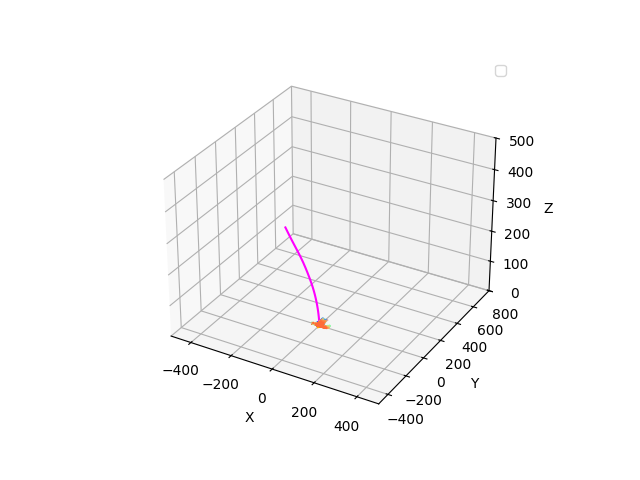

In [92]:
ax = plt.figure().add_subplot(projection='3d')
pts_to_show = list([point_clouds[n] for n in range(num_of_frames)])
#pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, point_cloud in zip(colors, pts_to_show):
    size = len(point_cloud.T[0])
    choices = np.random.choice(size, size=1000, replace=False)
    x = point_cloud.T[0][choices]
    y = point_cloud.T[1][choices]
    z = point_cloud.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.3, c=color)

ax.legend()
ax.plot(*pos_to_plot_truth, c='magenta')
ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-500, 800)
ax.set_zlim(0, 500)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [87]:
tm, rmse = IterativeClosestPoint(point_clouds[0], point_clouds[1])

In [88]:
t_matrices = []
aligned_pc = []
aligned_pc.append(np.column_stack((point_clouds[0],np.ones(point_clouds[0].shape[0]))))
for i in range(num_of_frames - 1):
    tm, rmse = IterativeClosestPoint(point_clouds[i], point_clouds[i+1])
    p = np.column_stack((point_clouds[i+1],np.ones(point_clouds[i+1].shape[0])))
    print(tm)
    p = np.array([tm @ q.T for q in p])
    print(p[0], "\n=============")
    #print(p, "\n=========================\n")
    aligned_pc.append(p)
    t_matrices.append(tm)

[[ 9.99998886e-01  9.84993974e-04 -1.12178730e-03  6.13371990e-03]
 [-9.84456103e-04  9.99999400e-01  4.79928508e-04 -5.22046920e-01]
 [ 1.12225935e-03 -4.78823623e-04  9.99999256e-01 -5.73953197e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-9.03335409 17.43726207  0.86383955  1.        ] 
[[ 9.99995128e-01  3.06578435e-03  5.86596954e-04  9.86398267e-03]
 [-3.06560939e-03  9.99995256e-01 -2.98938366e-04 -5.06084185e-01]
 [-5.87510652e-04  2.97138633e-04  9.99999783e-01 -3.59367650e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-8.90561864 16.88781684  0.87623401  1.        ] 
[[ 9.99994928e-01  3.16643414e-03  3.41996587e-04  1.45162434e-02]
 [-3.16652342e-03  9.99994953e-01  2.60835883e-04 -5.24879691e-01]
 [-3.41168942e-04 -2.61917500e-04  9.99999908e-01  2.34509885e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-8.82483416 16.13632498  0.84747336  1.        ] 
[[ 9.99991856e-01  3.98715528e-03  6.253

[[ 9.99998886e-01  9.84993974e-04 -1.12178730e-03  6.13371990e-03]
 [-9.84456103e-04  9.99999400e-01  4.79928508e-04 -5.22046920e-01]
 [ 1.12225935e-03 -4.78823623e-04  9.99999256e-01 -5.73953197e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.056182 17.949978  0.888338  1.      ]
 [-9.106149 17.908581  0.887326  1.      ]
 [-9.184107 17.92219   0.889309  1.      ]
 ...
 [ 1.426188  3.824943 -1.765563  1.      ]
 [ 1.42221   3.849532 -1.775574  1.      ]
 [ 1.414232  3.863128 -1.780585  1.      ]]
[[-9.03335409 17.43726207  0.86383955  1.        ]
 [-9.08336068 17.3959138   0.8627913   1.        ]
 [-9.16130741 17.40960049  0.86468029  1.        ]
 ...
 [ 1.43806826  3.30064242 -1.77153214  1.        ]
 [ 1.43412572  3.32523052 -1.78155937  1.        ]
 [ 1.42616674  3.33883196 -1.78658583  1.        ]]


/tmp/ipykernel_311997/3943595277.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


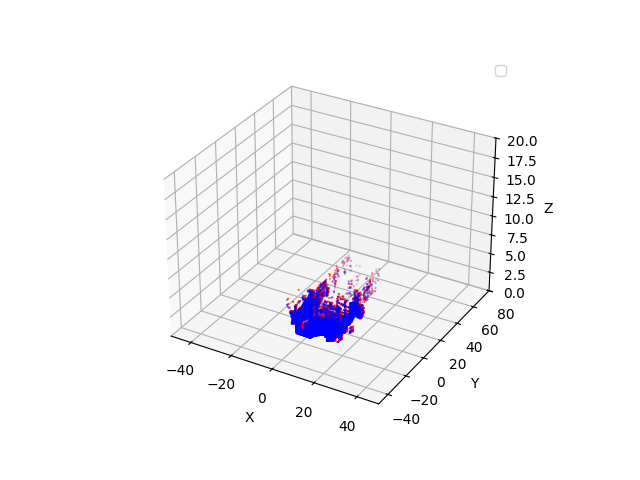

In [93]:
frame1 = 0
frame2 = 1

tm, _ = IterativeClosestPoint(point_clouds[frame1], point_clouds[frame2])
print(tm)

ax = plt.figure().add_subplot(projection='3d')

size = len(point_clouds[frame1])
choices = np.random.choice(size, size=20000, replace=False)
x = point_clouds[frame1].T[0][choices]
y = point_clouds[frame1].T[1][choices]
z = point_clouds[frame1].T[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.3, c='red')

p = np.append(point_clouds[frame2], [[1]] * point_clouds[frame2].shape[0], axis = 1)
print(p)
p = np.array([tm @ q for q in p]).T
#p = p.T
print(p.T)

size = len(point_clouds[frame2])
choices = np.random.choice(size, size=20000, replace=False)

x = p[0][choices]
y = p[1][choices]
z = p[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.1, c='blue')
#ax.plot(*pos_to_plot_truth, c='blue')
#ax.plot(*pos_to_plot, c='orange')

ax.legend()

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [89]:
real_position = np.eye(4,4)
groun_truth_transformation_matrix = np.load("./ground_truth.npy")
ground_truth_positions = []

lidar_position = np.eye(4,4)
positions = []

positions.append(lidar_position)
for tm, gt in zip(t_matrices, groun_truth_transformation_matrix):
    real_position = gt @ real_position
    ground_truth_positions.append(real_position)
    
    lidar_position = tm @ lidar_position
    positions.append(lidar_position)

positions = np.array(positions)
ground_truth_positions = np.array(ground_truth_positions)
#print(positions)

/tmp/ipykernel_311997/254296196.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


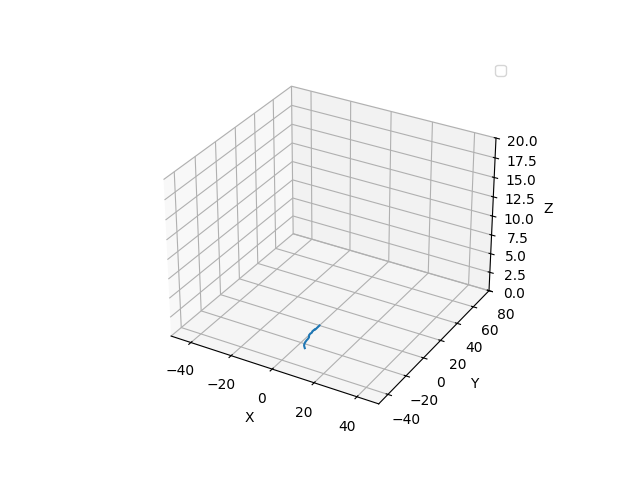

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot = positions[:,:3,3].T
ax.plot(*pos_to_plot)
#ax.plot(*positions[:,:3,3])
ax.legend()
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

/tmp/ipykernel_311997/1909506114.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


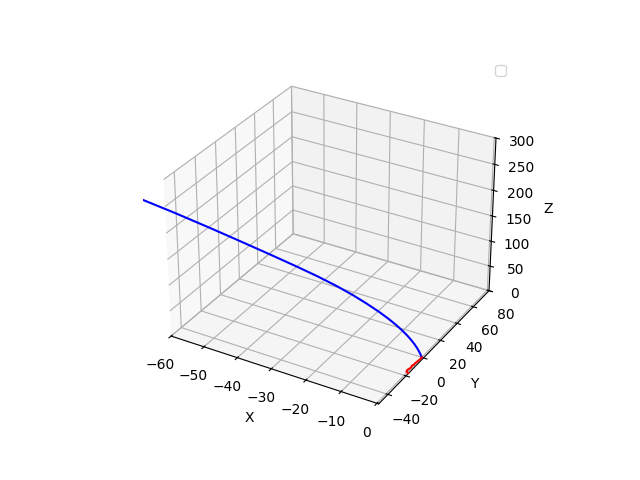

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot_truth = ground_truth_positions[:,:3,3].T
ax.plot(*pos_to_plot_truth, c='blue')
ax.plot(*pos_to_plot, c='red')
ax.legend()
ax.set_xlim(-60, 0.5)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 300)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

/tmp/ipykernel_311997/2180139182.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.1, c=color)
/tmp/ipykernel_311997/2180139182.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


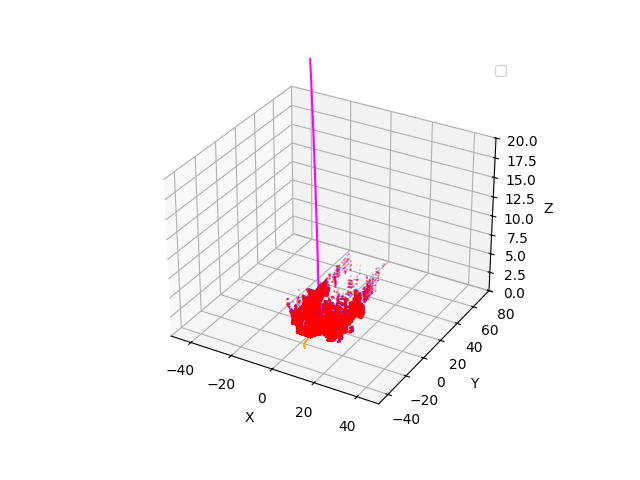

In [53]:
ax = plt.figure().add_subplot(projection='3d')
#pts_to_show = list([aligned_pc[n] for n in range(len(aligned_pc))])
pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, apc in zip(colors, pts_to_show):
    size = len(apc.T[0])
    choices = np.random.choice(size, size=50000, replace=False)
    x = apc.T[0][choices]
    y = apc.T[1][choices]
    z = apc.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.1, c=color)

ax.legend()
ax.plot(*pos_to_plot_truth, c='magenta')
ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()